In [1]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN  

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  

    def forward(self, t, y):
        S, I, R= y
        neural_output = self.neural_part(torch.tensor([S,I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

In [ ]:
gamma = 0.07
beta = 2 * gamma 
neural_ode_func = EKAN(layers_hidden=[2, 64, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  
last= 120.    
step = 120    
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  
t = torch.linspace(intial, last, step)  

In [6]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R= y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [7]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

In [8]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [9]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(5000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [10]:
t, true_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.07538700848817825, Accuracy: 4.17%
Iter 100, Loss: 0.0004994068876840174, Accuracy: 30.00%
Iter 200, Loss: 0.00025535846361890435, Accuracy: 34.17%
Iter 300, Loss: 0.0002147921040887013, Accuracy: 36.67%
Iter 400, Loss: 0.0001830241089919582, Accuracy: 39.17%
Iter 500, Loss: 0.0001518775534350425, Accuracy: 44.17%
Iter 600, Loss: 0.00012256008631084114, Accuracy: 47.50%
Iter 700, Loss: 9.613632573746145e-05, Accuracy: 55.00%
Iter 800, Loss: 7.325426122406498e-05, Accuracy: 64.17%
Iter 900, Loss: 5.417443753685802e-05, Accuracy: 80.00%
Iter 1000, Loss: 3.885501791955903e-05, Accuracy: 97.50%
Iter 1100, Loss: 2.7005522497347556e-05, Accuracy: 100.00%
Iter 1200, Loss: 1.8183636711910367e-05, Accuracy: 100.00%
Iter 1300, Loss: 1.1864401130878832e-05, Accuracy: 100.00%
Iter 1400, Loss: 7.513528089475585e-06, Accuracy: 100.00%
Iter 1500, Loss: 4.638383870769758e-06, Accuracy: 100.00%
Iter 1600, Loss: 2.814468643919099e-06, Accuracy: 100.00%
Iter 1700, Loss: 1.7077757092920365

In [ ]:
def forword_CF(x):
    
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
   
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")

    result = x.clone().detach()
    
 
    result[1:] = x[1:] - x[:-1]
    
    return result

In [12]:
true_y[:,2] = forword_CF(true_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2926839/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [13]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
}
df = pd.DataFrame(data)


In [14]:
df.to_excel('result/KAN/kan2-64-1.xlsx', index=False)

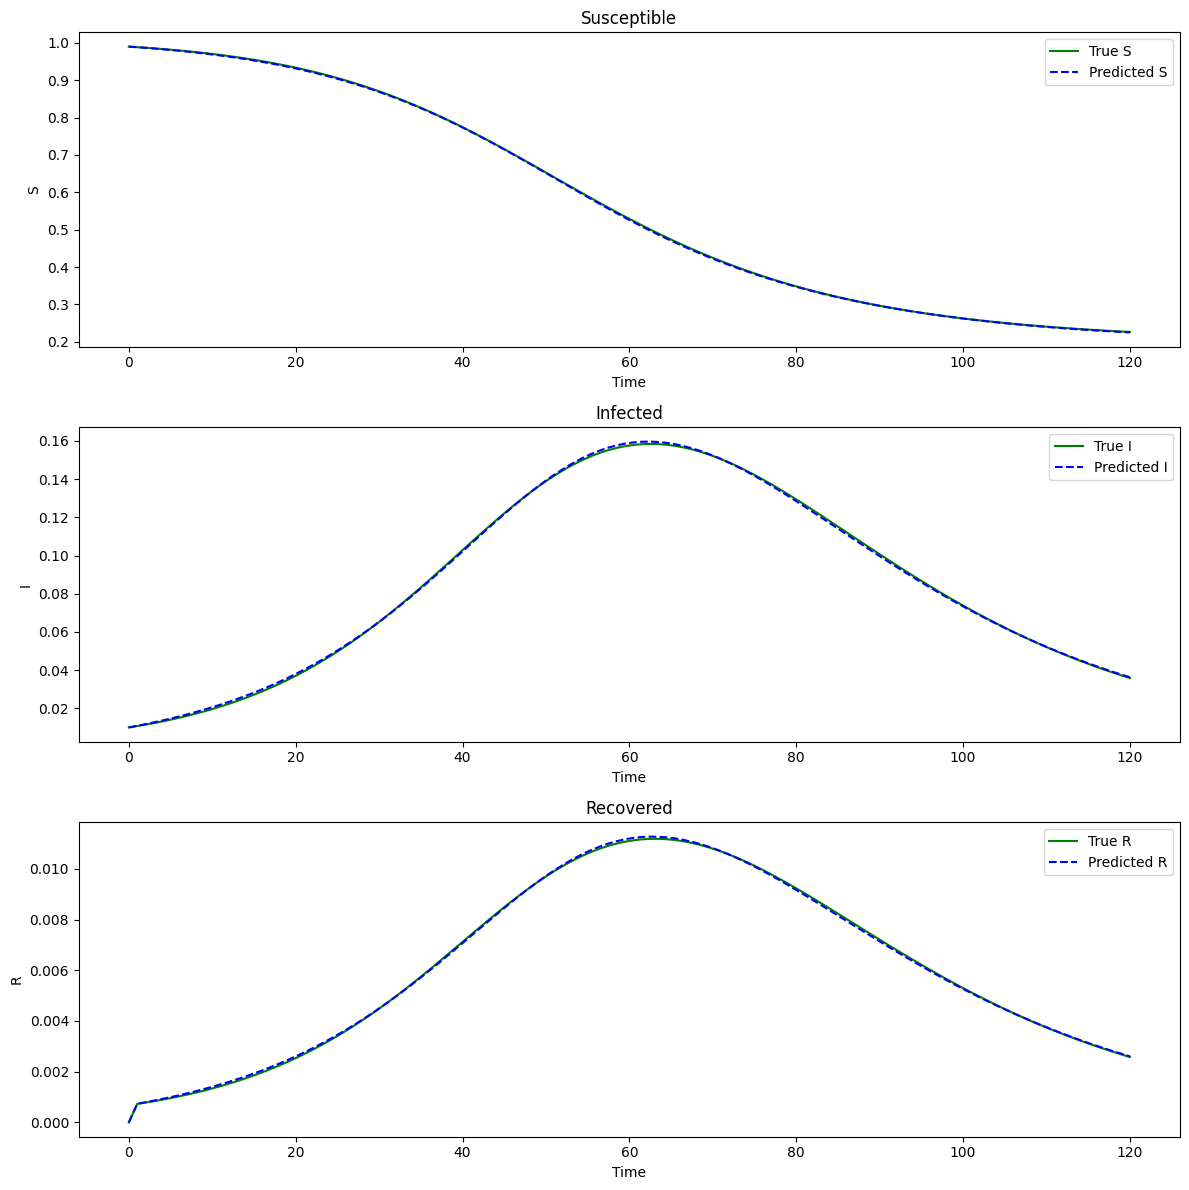

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/KAN/kan2-64-1_SIR.png')
plt.show()
